# **CNN Lab**


## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>


In [65]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [66]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
## Each image is a 32 x 32 x 3 numpy array
x_train[522].shape

(32, 32, 3)

[9]


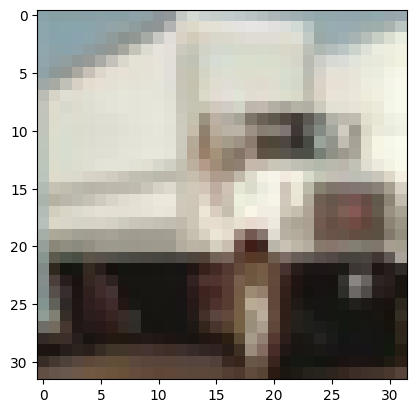

In [ ]:
## Let's look at one of the images

print(y_train[444])
plt.imshow(x_train[444]);

In [ ]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
# Let's build a CNN using Keras' Sequential capabilities

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [ ]:
## Check number of parameters

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [ ]:
# initiate RMSprop optimizer
opt_2 = keras.optimizers.RMSprop(lr=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [ ]:
model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 298s 190ms/step - loss: 1.5380 - accuracy: 0.4452 - val_loss: 1.2100 - val_accuracy: 0.5637
Epoch 2/5
1563/1563 [==============================] - 301s 193ms/step - loss: 1.1185 - accuracy: 0.6080 - val_loss: 1.0736 - val_accuracy: 0.6319
Epoch 3/5
1563/1563 [==============================] - 293s 188ms/step - loss: 0.9751 - accuracy: 0.6610 - val_loss: 0.9161 - val_accuracy: 0.6918
Epoch 4/5
1563/1563 [==============================] - 303s 194ms/step - loss: 0.9133 - accuracy: 0.6878 - val_loss: 0.8963 - val_accuracy: 0.6887
Epoch 5/5
1563/1563 [==============================] - 297s 190ms/step - loss: 0.8791 - accuracy: 0.7009 - val_loss: 0.8917 - val_accuracy: 0.6950


In [ ]:
def plot_activations_multilayer(num_layers, images_per_row, classifier, activations):
    layer_names = []
    for layer in classifier.layers[:num_layers]:
        layer_names.append(layer.name + ' layer')  # Names of the layers, so you can have them as part of your plot
    for layer_name, layer_activation in zip(layer_names, activations):  # Displays the feature maps
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :,
                                                 col * images_per_row + row]
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2. / size
        plt.figure(figsize=(scale*display_grid.shape[1],
                            scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

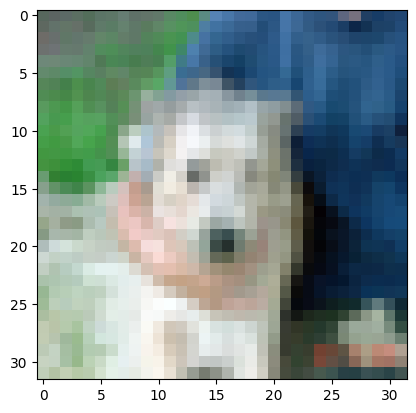

In [ ]:
plt.imshow(x_test[444])

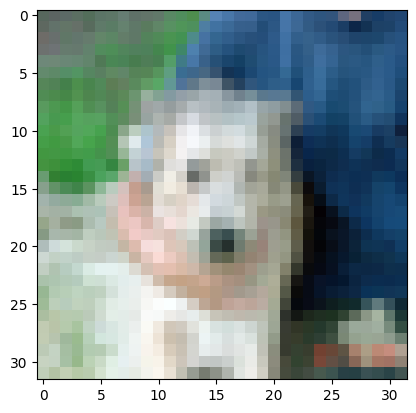

In [ ]:
# display the sample image
img_tensor = x_test[444]
plt.imshow(img_tensor)

In [ ]:
img_tensor = np.expand_dims(img_tensor, axis=0)
y = model_2.predict(img_tensor)
print(f"The predicted output of the sample image has a shape of {y.shape}.")

1/1 [==============================] - 0s 96ms/step
The predicted output of the sample image has a shape of (1, 10).


1/1 [==============================] - 0s 114ms/step


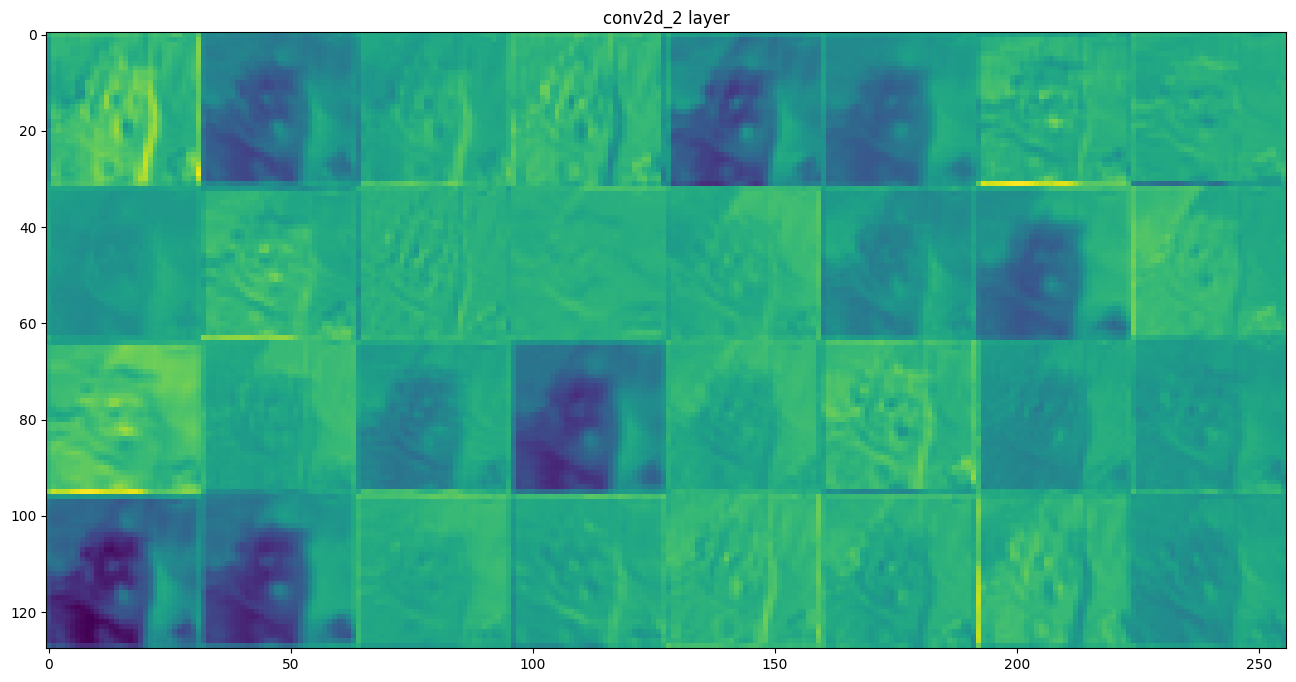

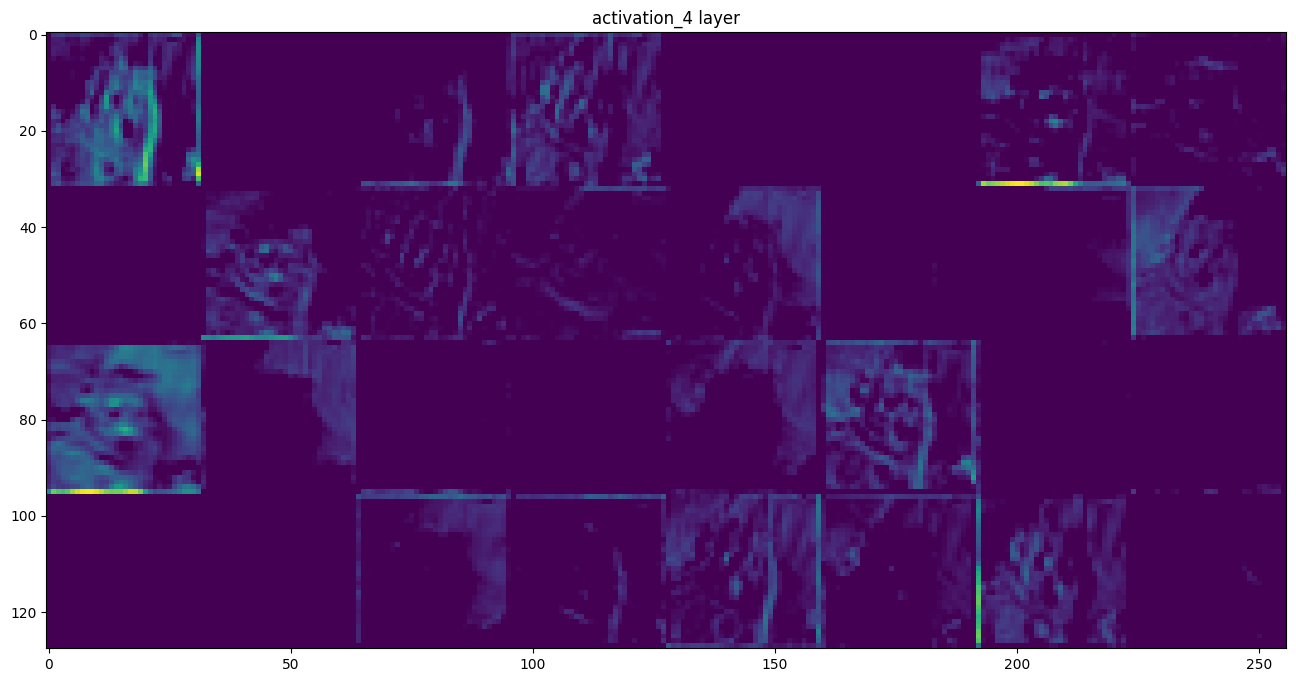

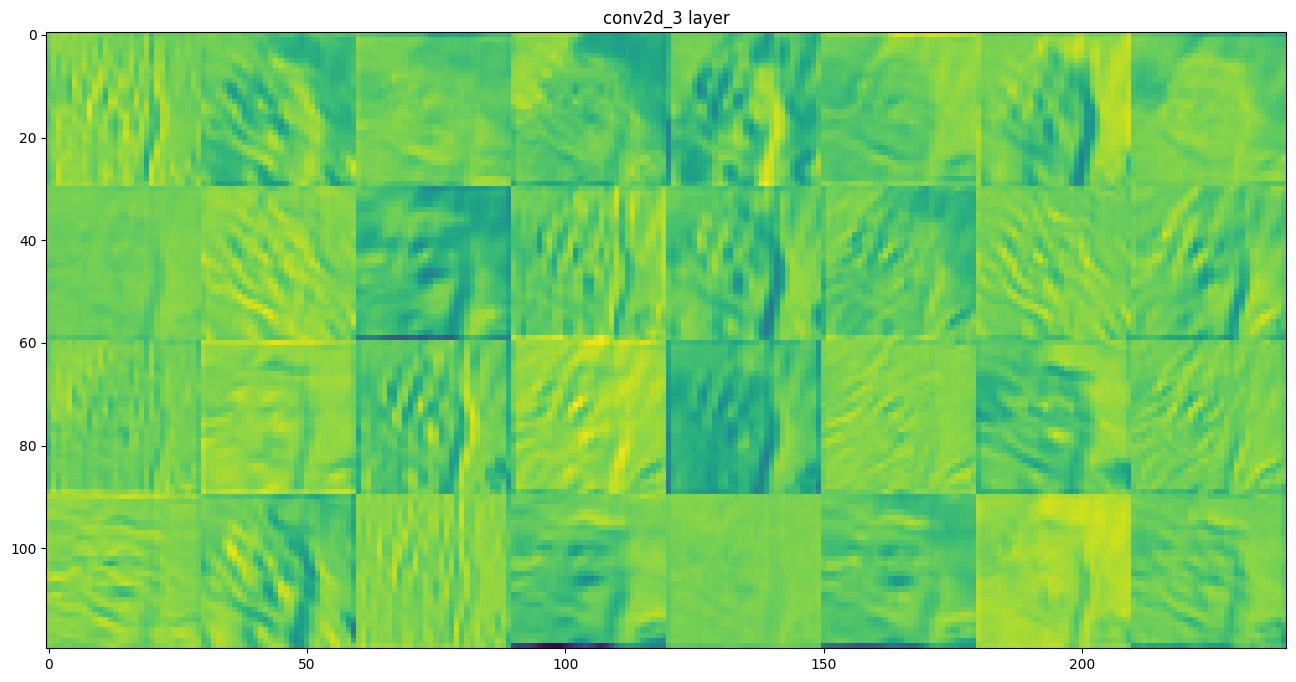

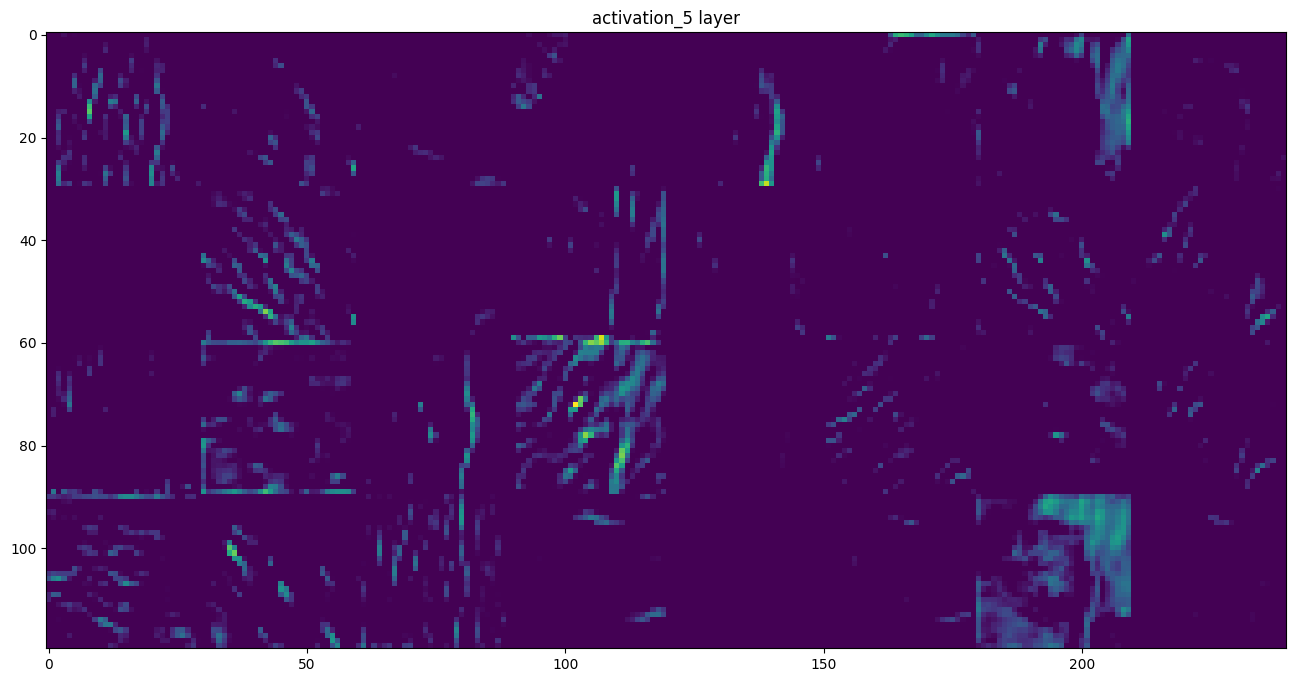

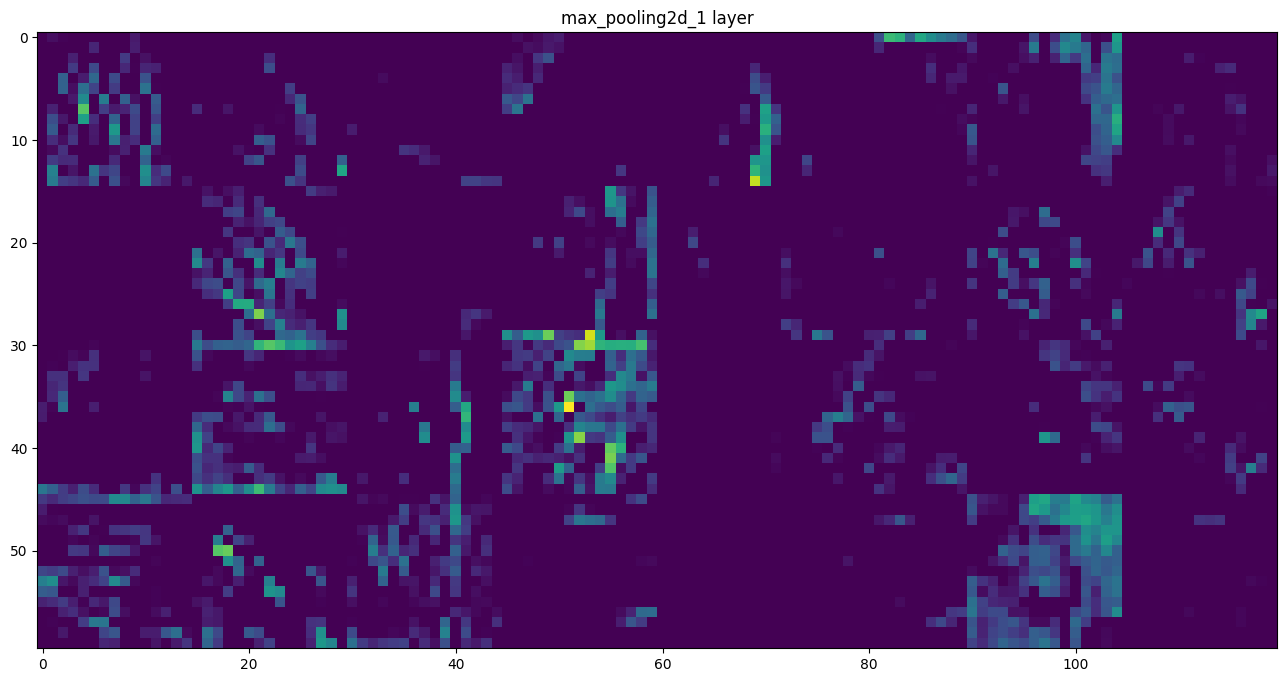

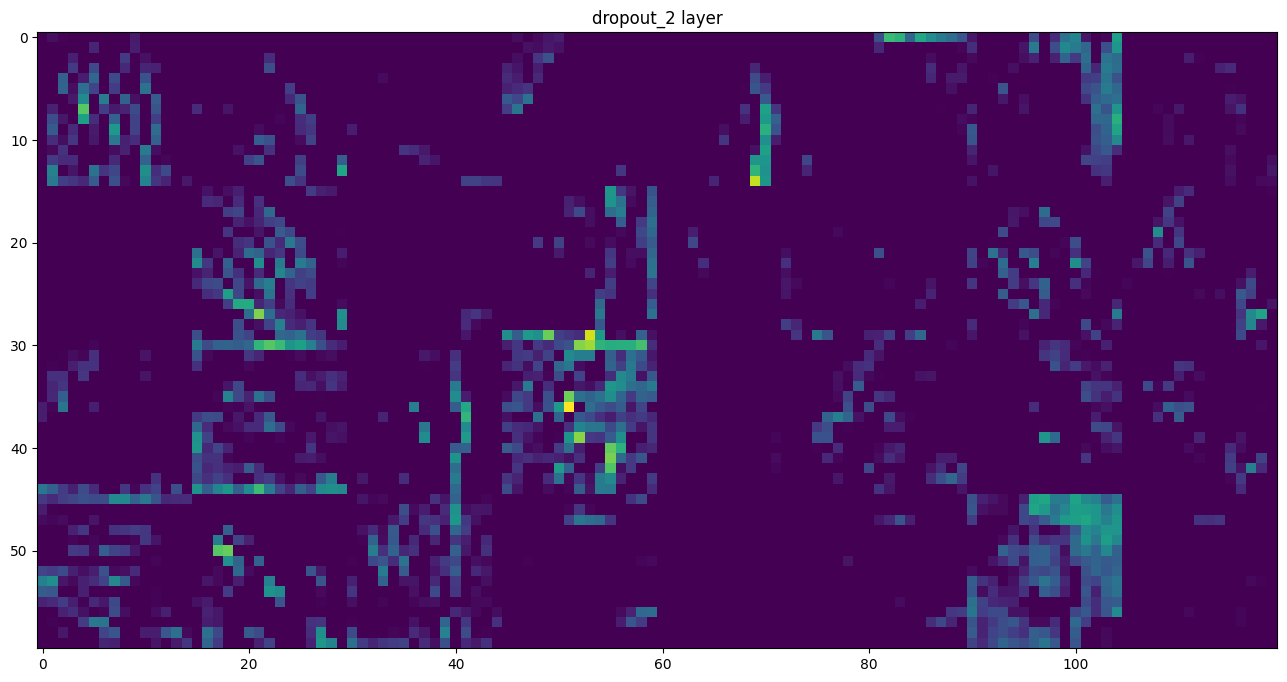

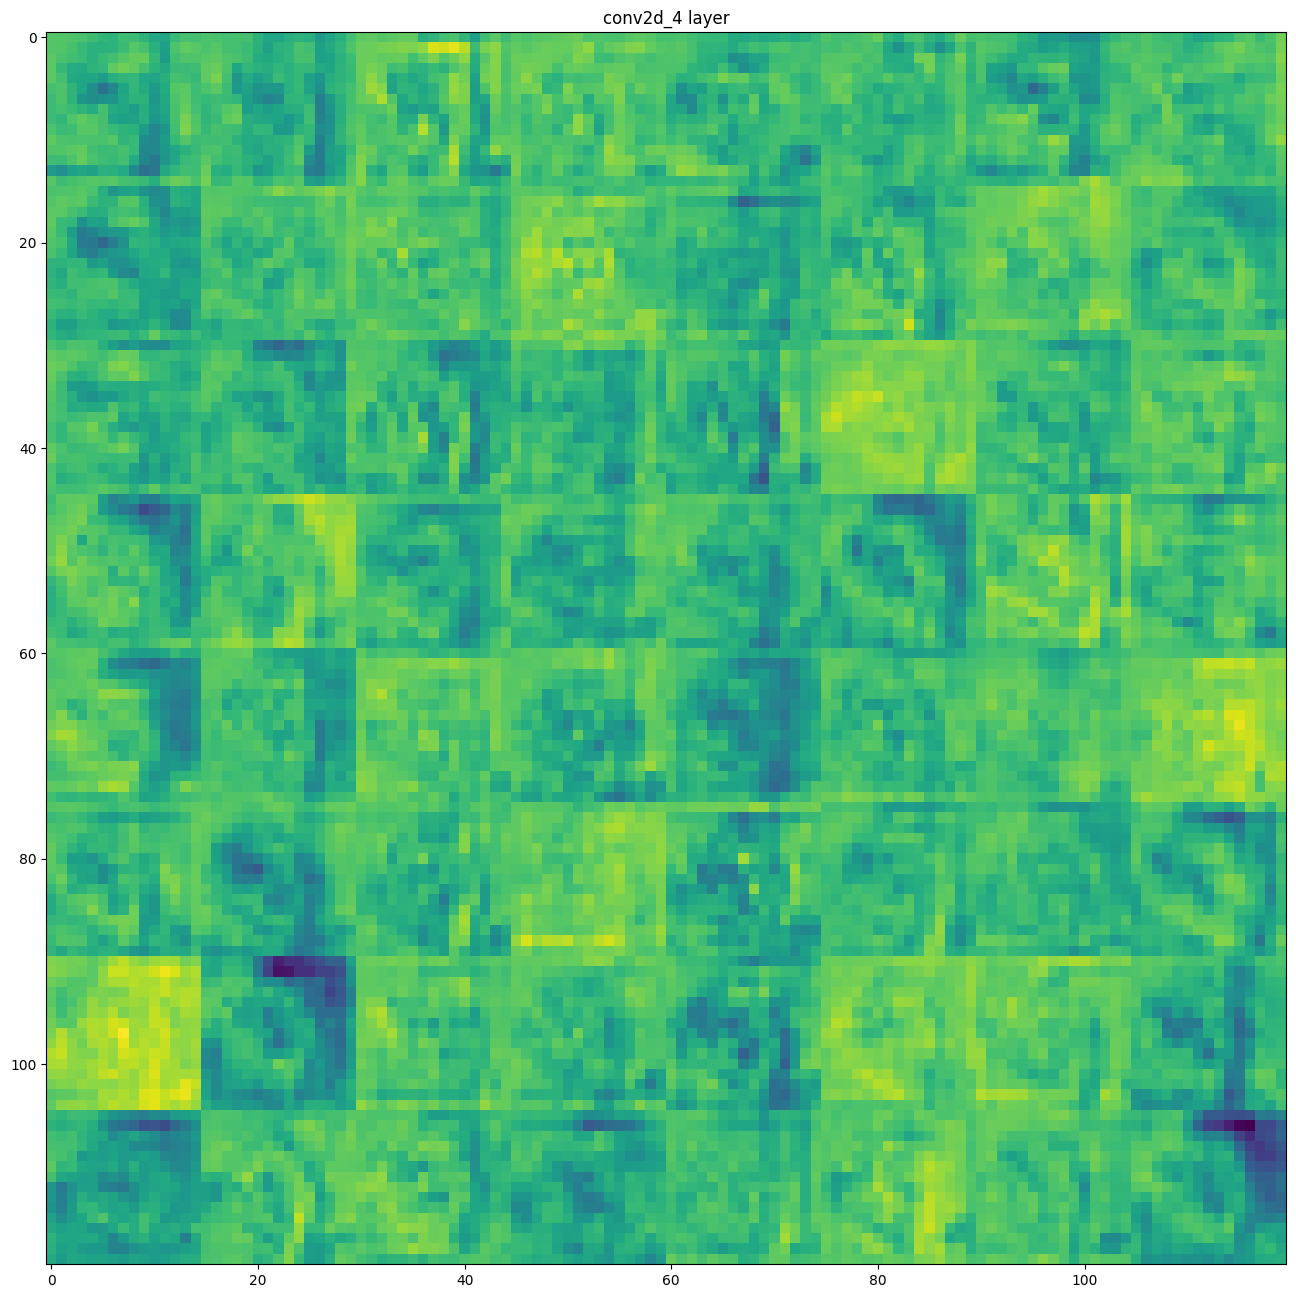

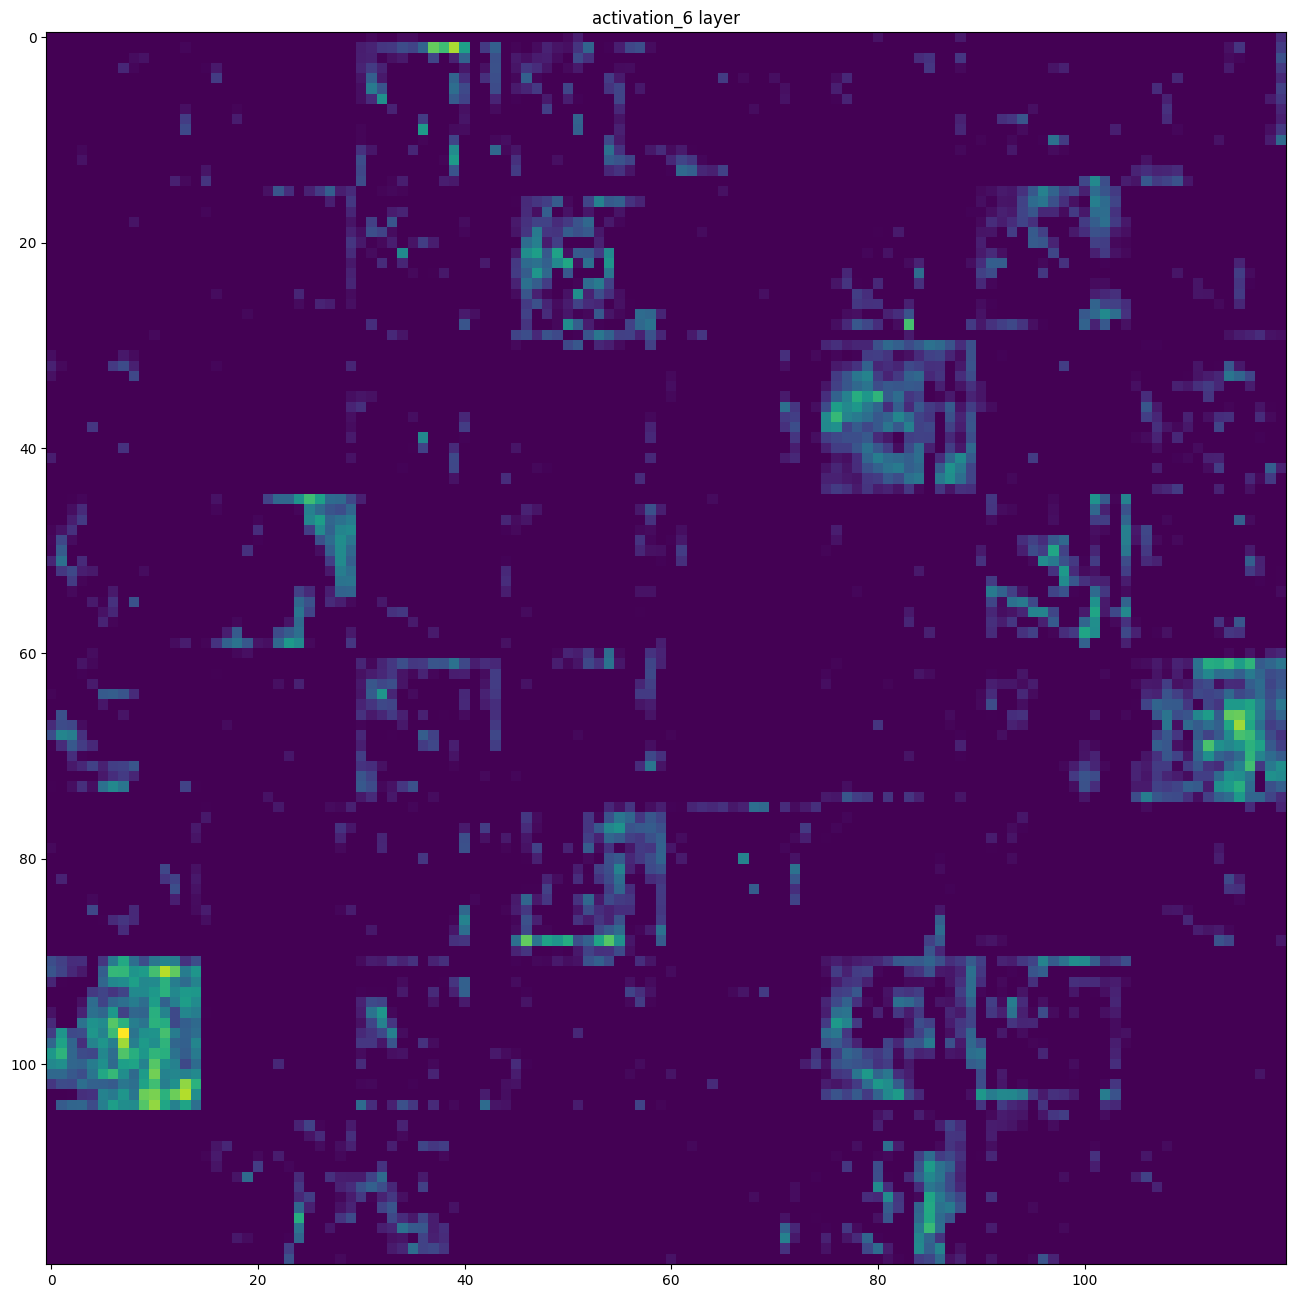

In [ ]:
layer_outputs = [layer.output for layer in model_2.layers] 
activation_model = Model(inputs=model_2.input, outputs=layer_outputs) 
activations = activation_model.predict(img_tensor)

plot_activations_multilayer(8, 8, model_2, activations)

1/1 [==============================] - 0s 24ms/step


Text(0.5, 1.0, 'Predicted class is: Dog')

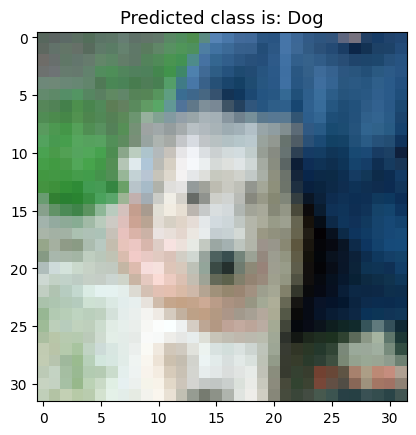

In [ ]:
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
y = model_2.predict(img_tensor)
label = class_names[np.argmax(y)]
plt.imshow(img_tensor.reshape((32,32,3)).astype("uint8"))
plt.title(f"Predicted class is: {label}", fontsize=13)

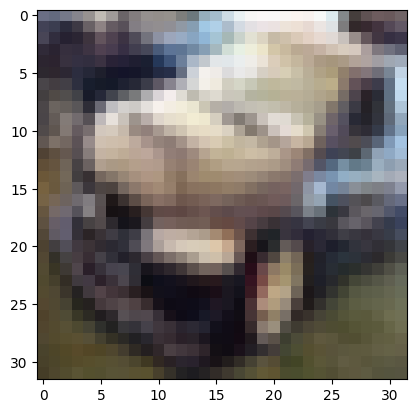

In [60]:
# display the sample image
img_tensor_2 = x_test[325]
plt.imshow(img_tensor_2)

In [61]:
img_tensor_2 = np.expand_dims(img_tensor_2, axis=0)
y = model_2.predict(img_tensor_2)
print(f"The predicted output of the sample image has a shape of {y.shape}.")

1/1 [==============================] - 0s 42ms/step
The predicted output of the sample image has a shape of (1, 10).


1/1 [==============================] - 0s 138ms/step


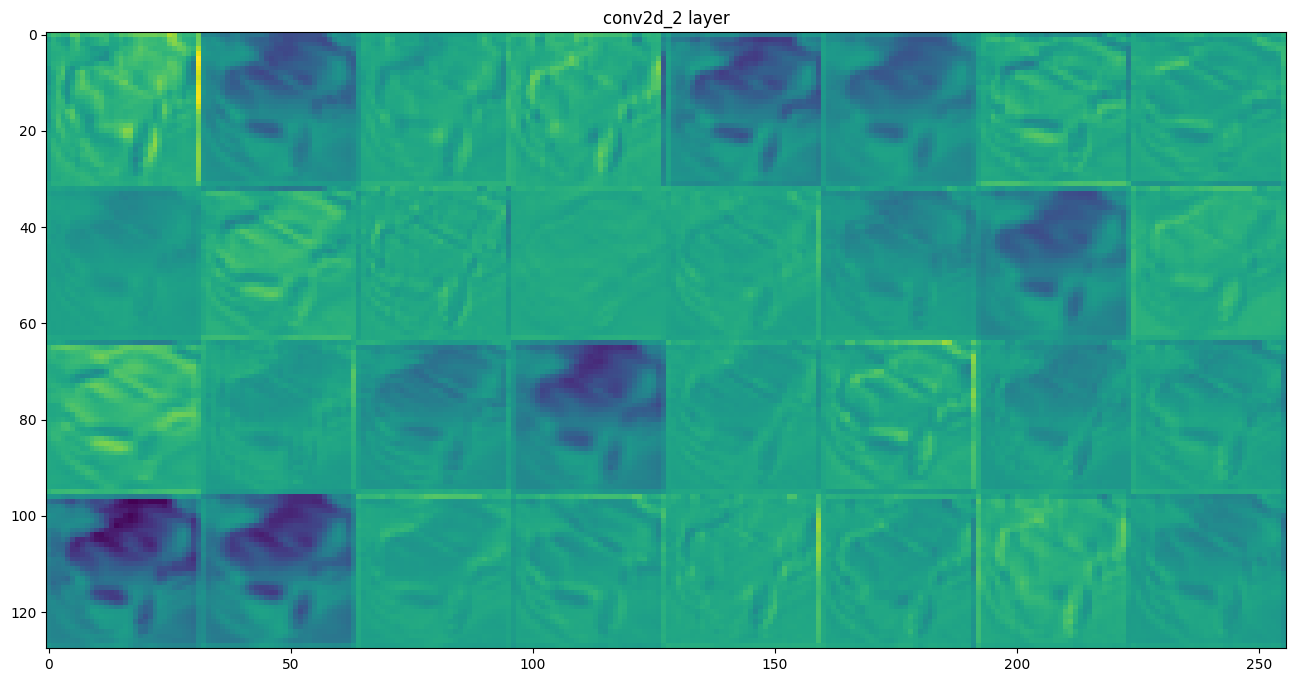

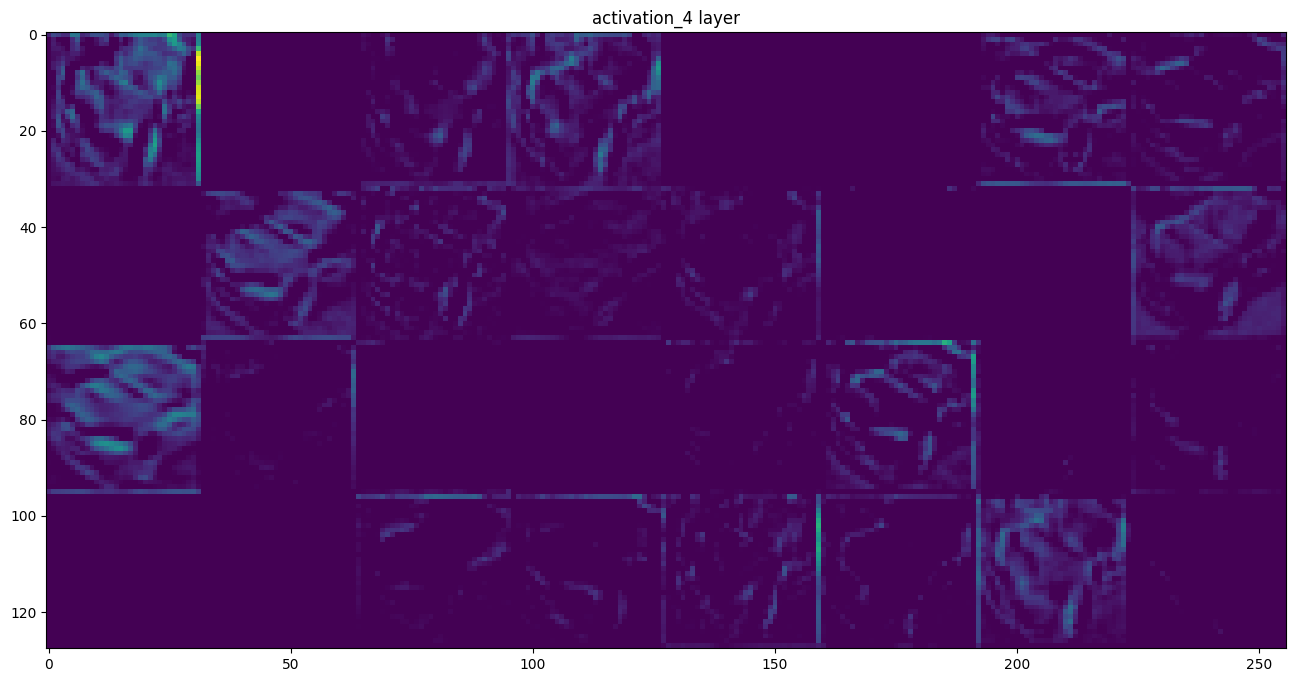

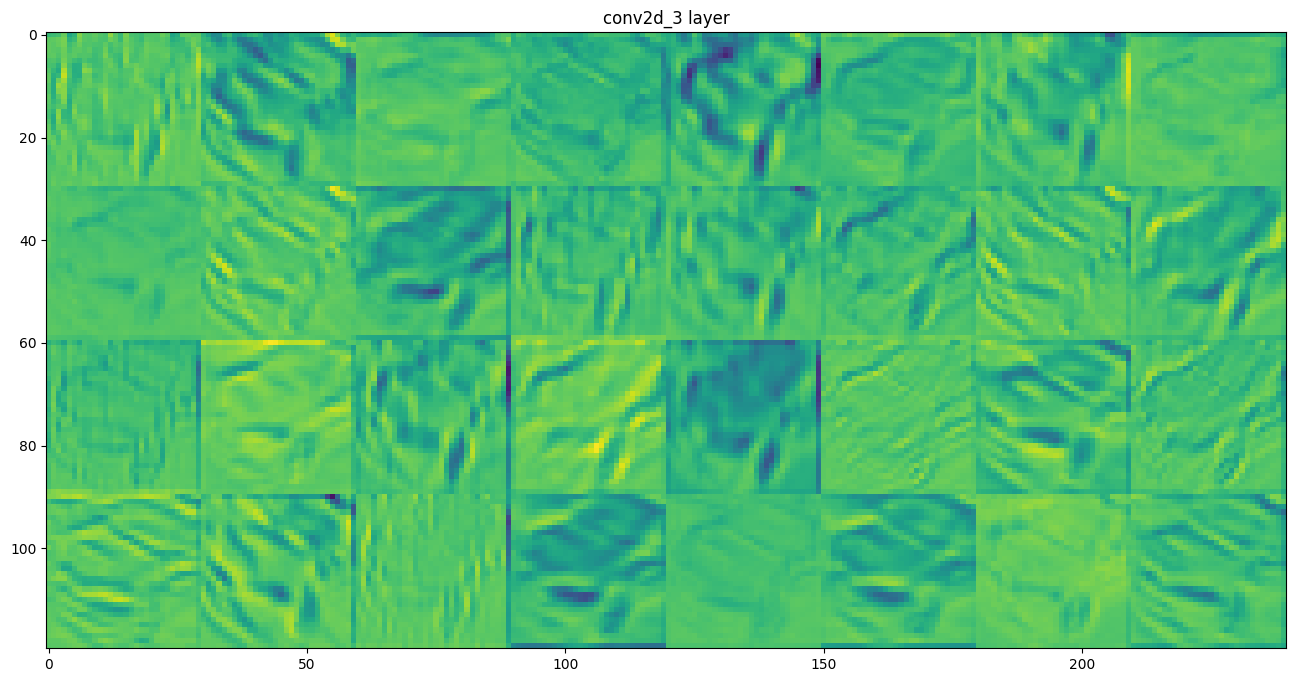

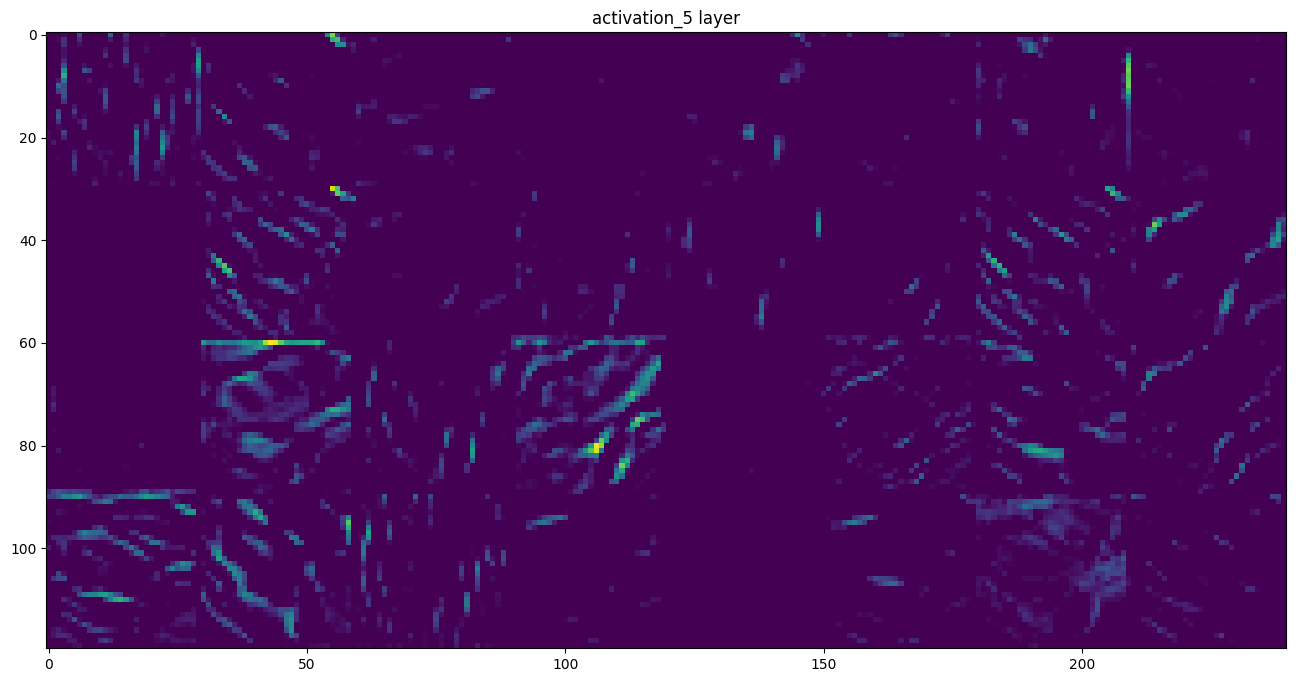

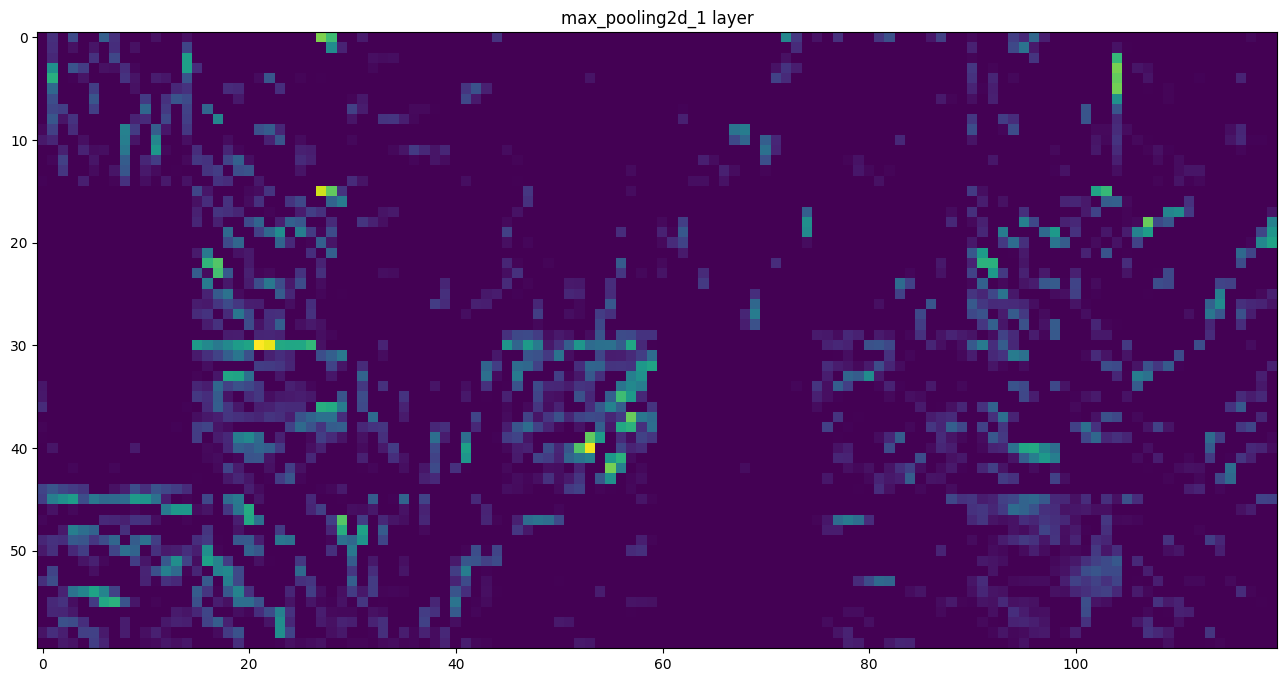

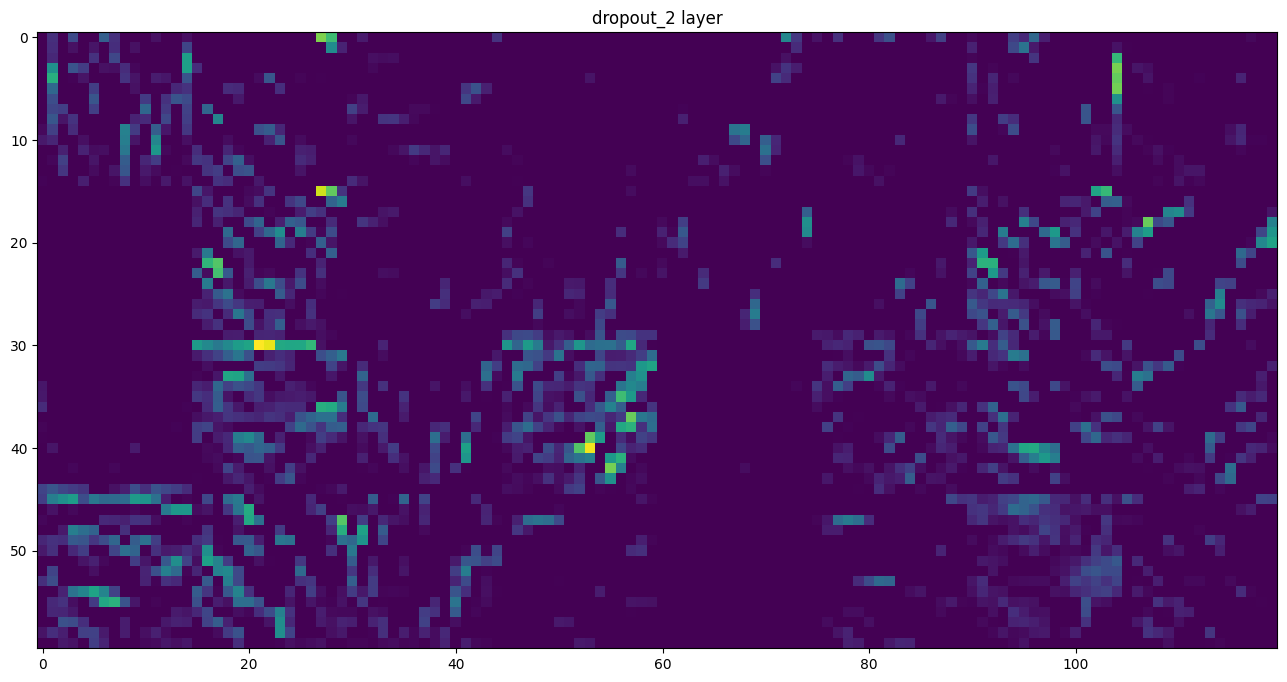

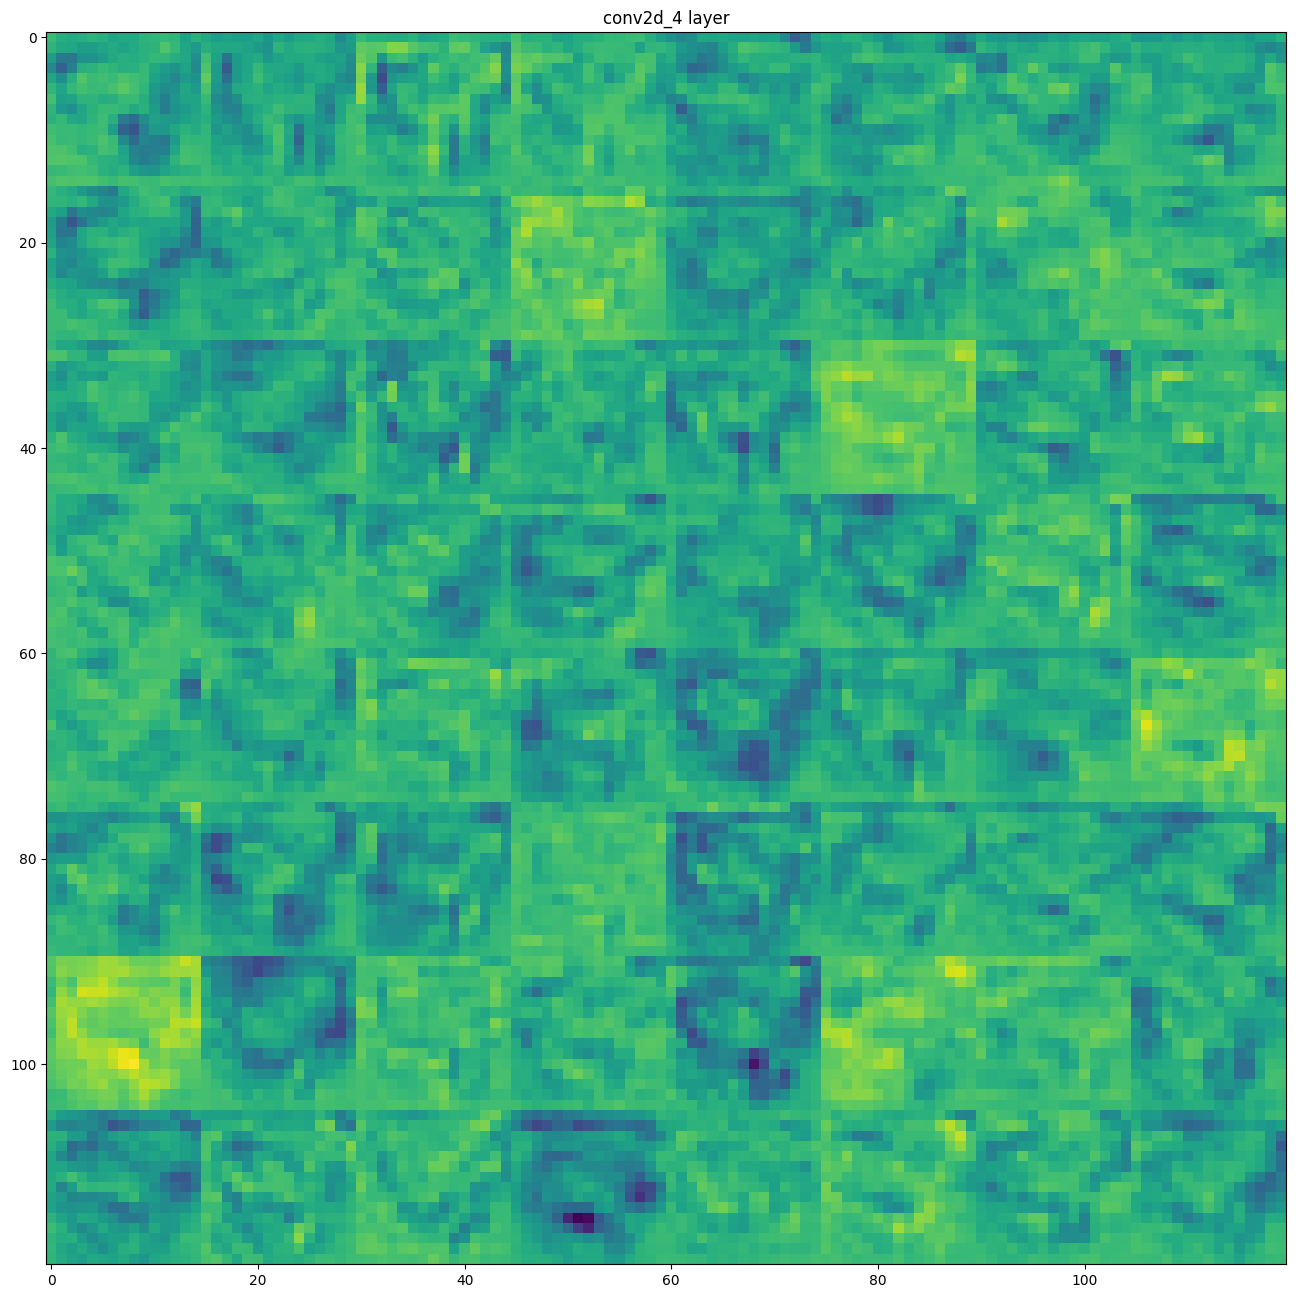

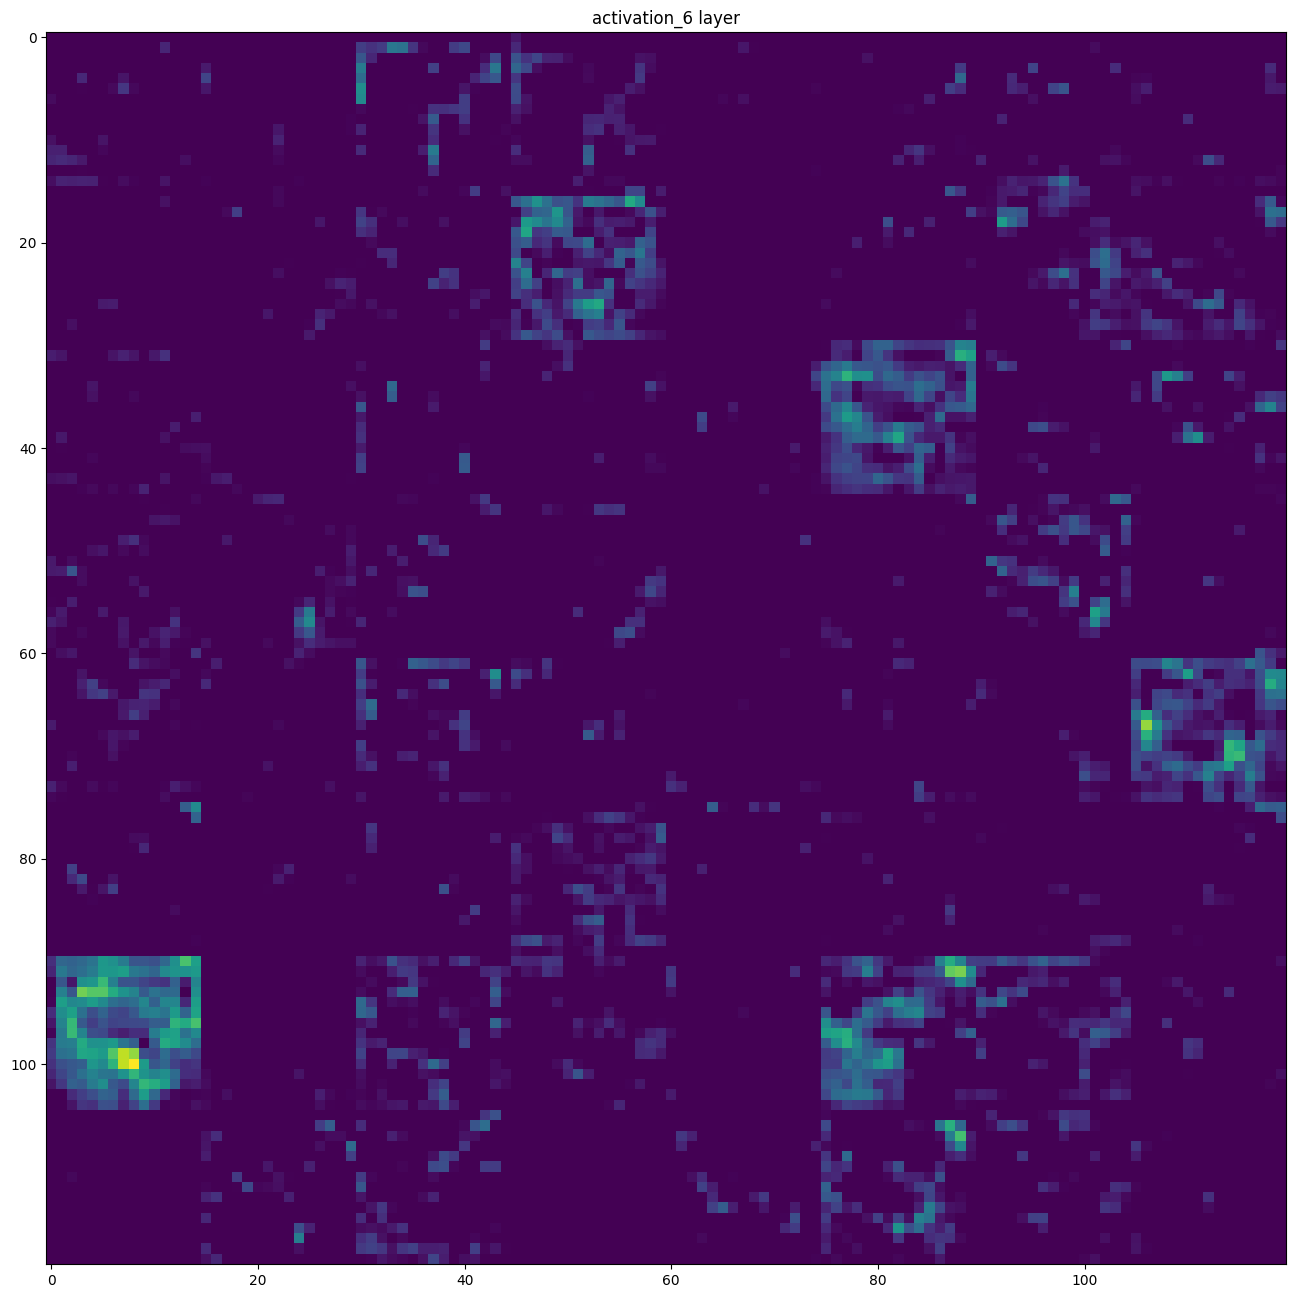

In [67]:
layer_outputs = [layer.output for layer in model_2.layers] 
activation_model = Model(inputs=model_2.input, outputs=layer_outputs) 
activations = activation_model.predict(img_tensor_2)

plot_activations_multilayer(8, 8, model_2, activations)

1/1 [==============================] - 0s 29ms/step


Text(0.5, 1.0, 'Predicted class is: Automobile')

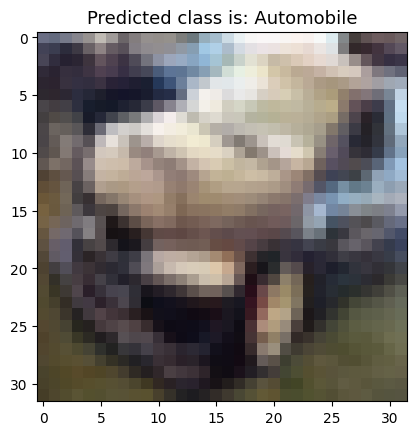

In [68]:
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
y = model_2.predict(img_tensor_2)
label = class_names[np.argmax(y)]
plt.imshow(img_tensor_2.reshape((32,32,3)).astype("uint8"))
plt.title(f"Predicted class is: {label}", fontsize=13)